In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import cv2

In [2]:

# --- 1. Load and Preprocess Data ---
print("Loading and preprocessing CIFAR-100 data...")
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# CIFAR-100 images are already in shape (32, 32, 3), so no need to add channel dimension
input_shape = x_train.shape[1:] # (32, 32, 3)
latent_dim = 128  # Increased latent dimension for more complex images


Loading and preprocessing CIFAR-100 data...


In [3]:

# --- 2. Build the Autoencoder Model ---
print("Building autoencoder model for CIFAR-100...")

# Encoder - deeper architecture for more complex images
encoder_input = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)                   # 16x16x32
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)                   # 8x8x64
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)                   # 4x4x128
x = Flatten()(x)
encoder_output = Dense(latent_dim, activation='relu')(x)     # Latent space

encoder = Model(encoder_input, encoder_output, name="encoder")

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(4 * 4 * 128, activation='relu')(decoder_input)    # Reshape for Conv2DTranspose
x = Reshape((4, 4, 128))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)                                  # 8x8x128
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)                                  # 16x16x64
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)                                  # 32x32x32
decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output RGB image (32x32x3)

decoder = Model(decoder_input, decoder_output, name="decoder")

# Autoencoder
autoencoder_output = decoder(encoder(encoder_input))
autoencoder = Model(encoder_input, autoencoder_output, name="autoencoder")

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Display model summaries
encoder.summary()
decoder.summary()
autoencoder.summary()


Building autoencoder model for CIFAR-100...


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,520 (1.36 MB)

 Trainable params: 355,520 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,899 (1.93 MB)

 Trainable params: 504,899 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │       355,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       504,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 860,419 (3.28 MB)

 Trainable params: 860,419 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

Training autoencoder on CIFAR-100...
Epoch 1/10
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.0367 - val_loss: 0.0161
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.0367 - val_loss: 0.0161
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - loss: 0.0130 - val_loss: 0.0119
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - loss: 0.0130 - val_loss: 0.0119
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - loss: 0.0103 - v

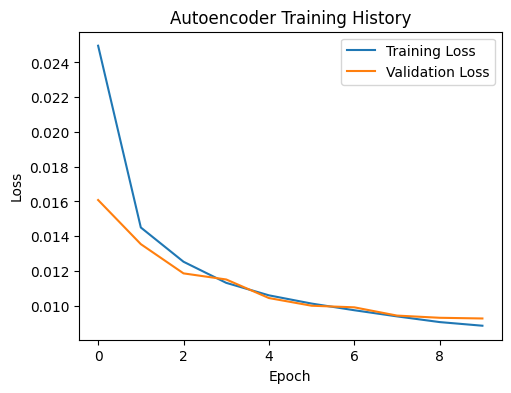

In [4]:

# --- 3. Train the Autoencoder ---
print("Training autoencoder on CIFAR-100...")
history = autoencoder.fit(x_train, x_train,
                          epochs=10,  # More epochs for more complex dataset
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test))

# --- 4. Extract Features and Perform Clustering ---
print("Extracting features and performing K-Means clustering...")
# Get the latent space representations from the encoder
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training History')
plt.show()

In [5]:

# For segmentation, we're clustering images based on their encoded features
# CIFAR-100 has 100 fine-grained classes, but we'll use a more reasonable number for visualization
n_clusters = 20  # Using 20 clusters instead of 100 for better visualization
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(x_train_encoded)  # Fit KMeans on the training latent features

# Predict cluster labels for test set
test_cluster_labels = kmeans.predict(x_test_encoded)

Visualizing results...


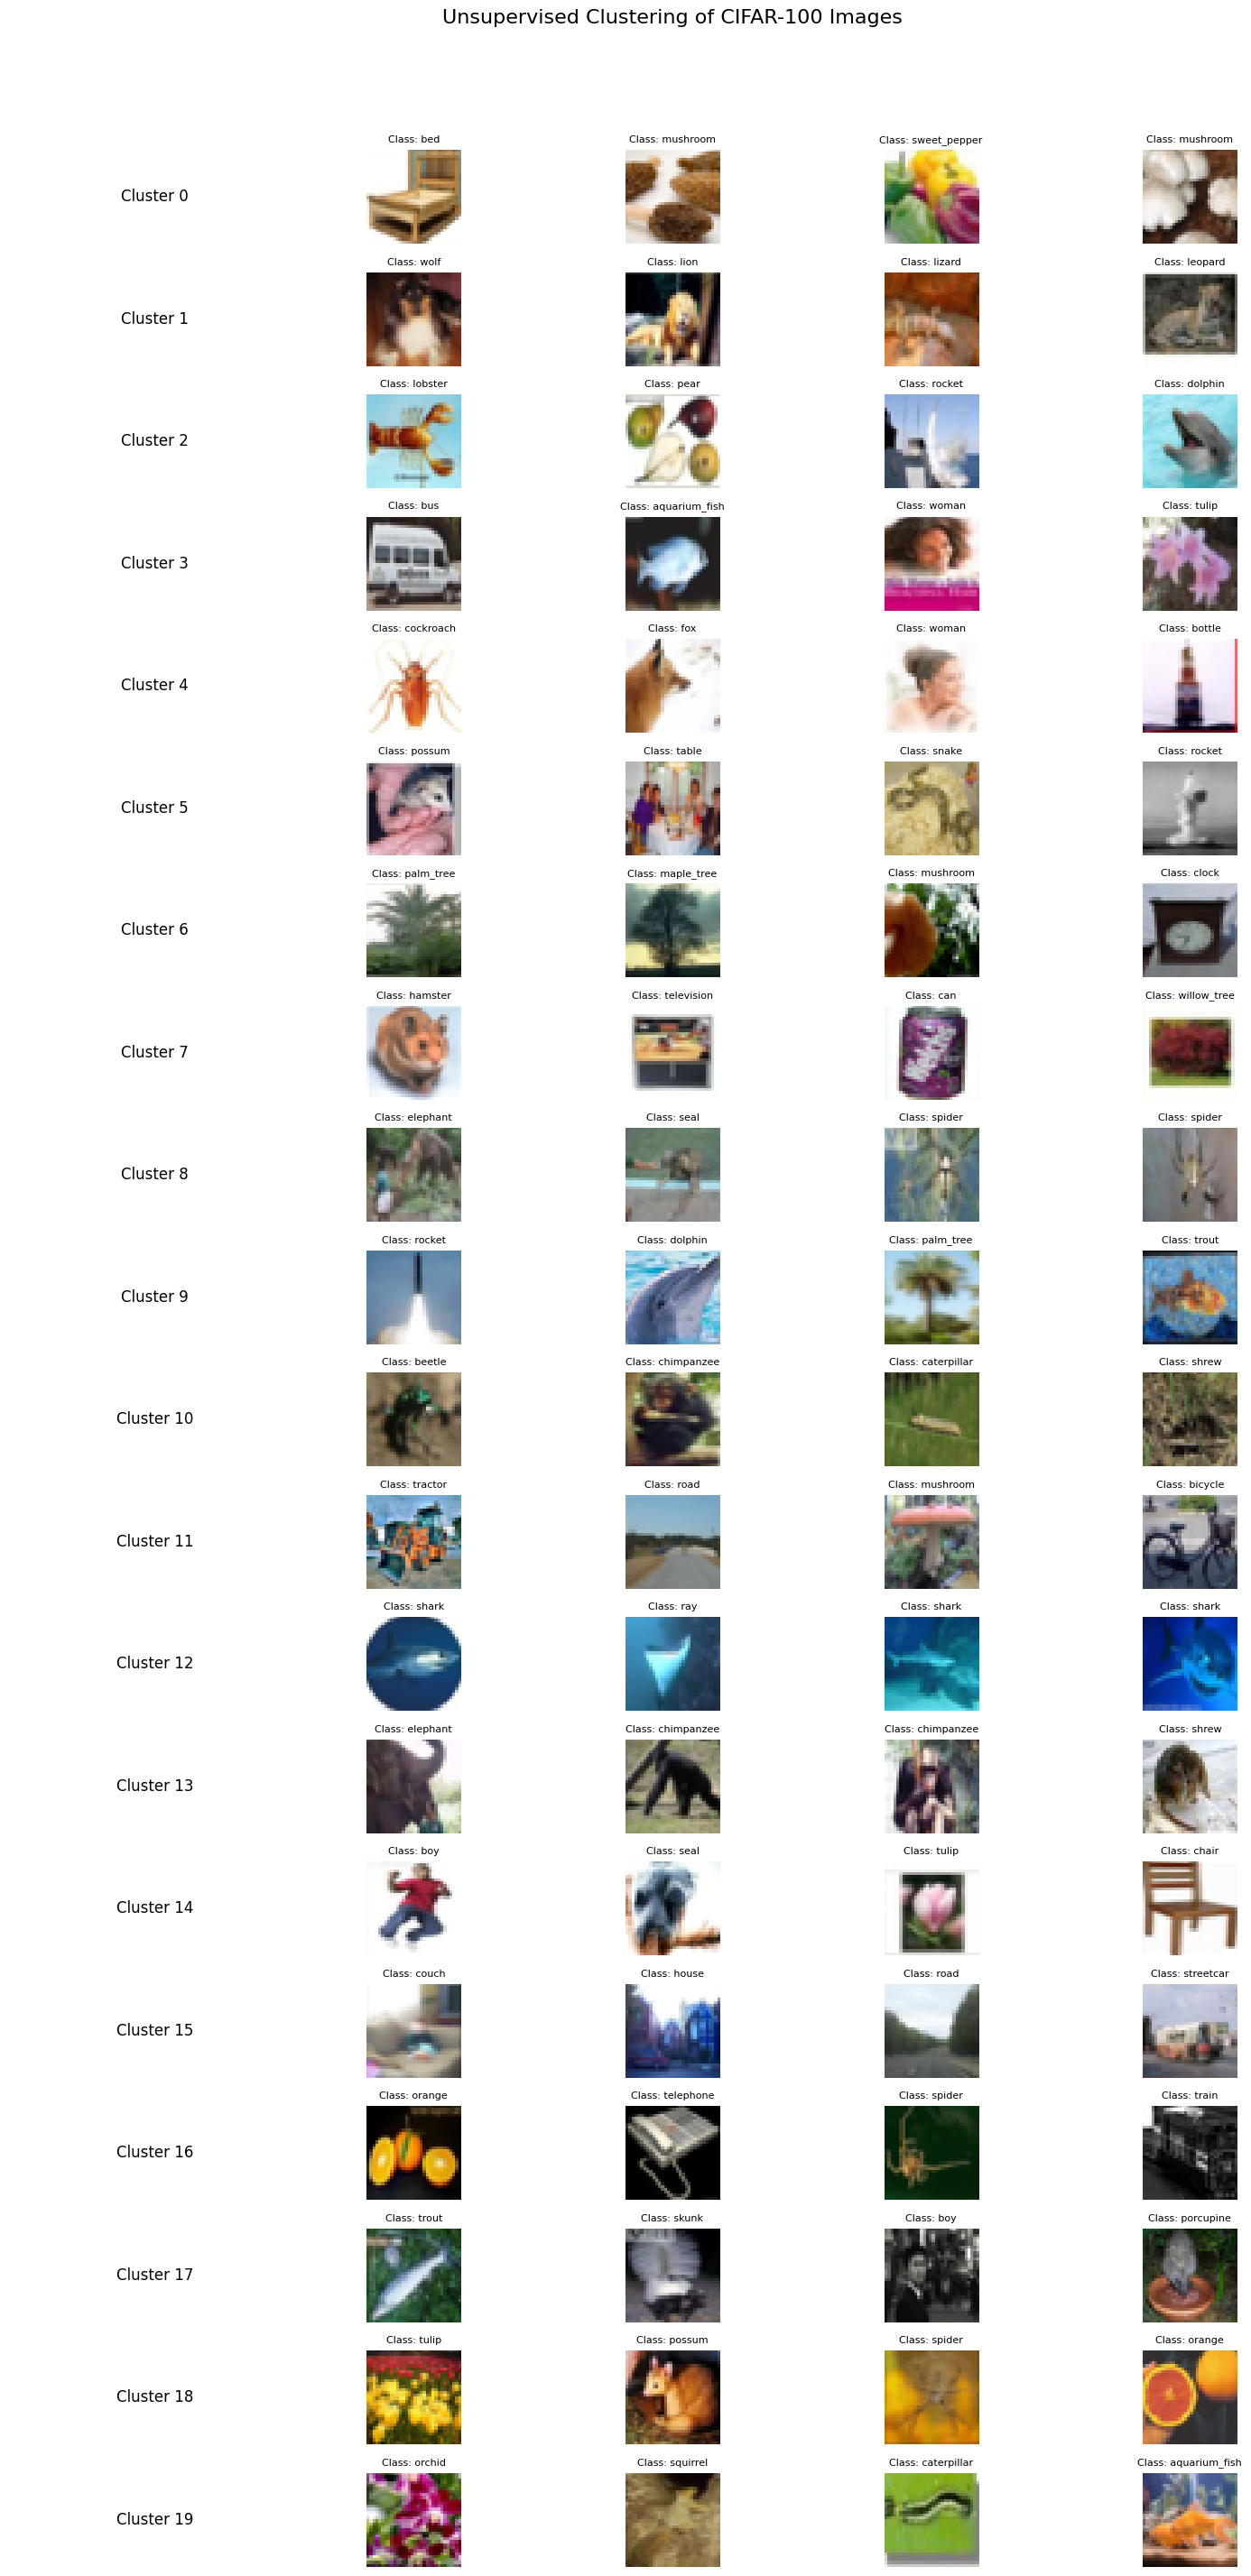

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


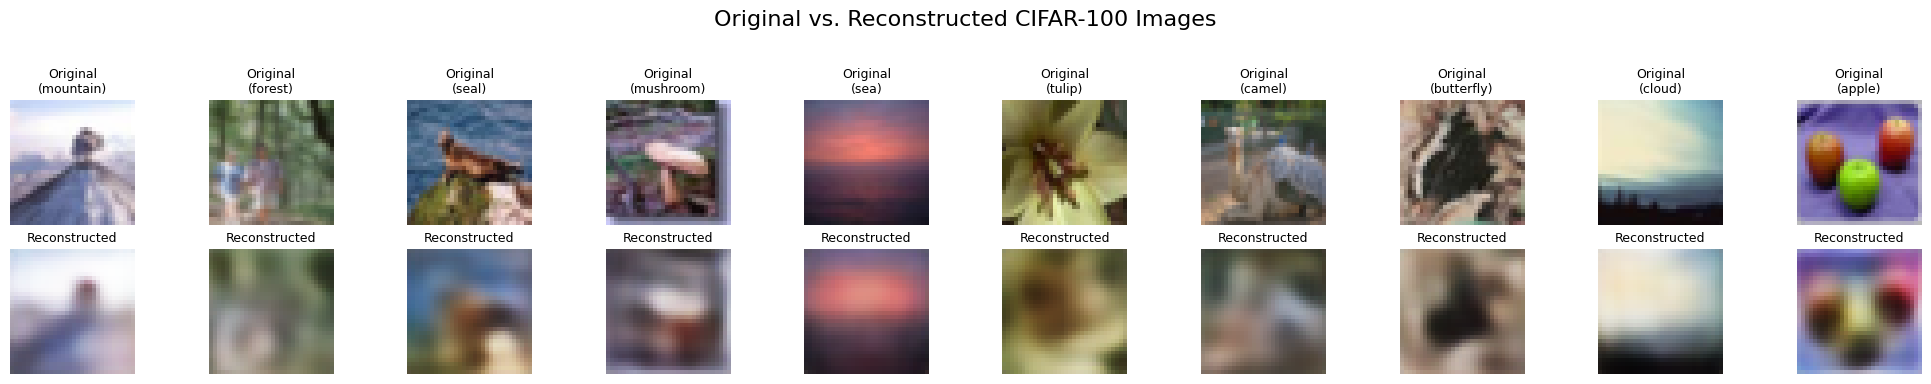

In [6]:

# --- 5. Visualize Results ---
print("Visualizing results...")

# Load CIFAR-100 class names
cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

def plot_images_in_clusters(images, true_labels, cluster_labels, n_examples=4):
    plt.figure(figsize=(15, n_clusters * 1.5))
    
    for i in range(n_clusters):
        # Find indices of images belonging to the current cluster
        cluster_indices = np.where(cluster_labels == i)[0]
        
        if len(cluster_indices) == 0:
            continue
            
        # Randomly select a few examples from this cluster
        np.random.shuffle(cluster_indices)
        
        for j in range(min(n_examples, len(cluster_indices))):
            idx = cluster_indices[j]
            ax = plt.subplot(n_clusters, n_examples + 1, i * (n_examples + 1) + j + 2)
            plt.imshow(images[idx])
            plt.title(f"Class: {cifar100_fine_labels[true_labels[idx][0]]}", fontsize=8)
            plt.axis('off')
        
        # Add a title for the cluster row
        ax = plt.subplot(n_clusters, n_examples + 1, i * (n_examples + 1) + 1)
        ax.text(0.5, 0.5, f"Cluster {i}", horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')

    plt.suptitle("Unsupervised Clustering of CIFAR-100 Images", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_images_in_clusters(x_test, y_test, test_cluster_labels)

# Visualize original vs reconstructed images
n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images):
    # Display original
    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Original\n({cifar100_fine_labels[y_test[i][0]]})", fontsize=9)
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(autoencoder.predict(x_test[i:i+1])[0])
    plt.title("Reconstructed", fontsize=9)
    plt.axis('off')
plt.suptitle("Original vs. Reconstructed CIFAR-100 Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Demonstrating pixel-wise segmentation using the trained autoencoder ---
Selected image class: clock
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Extracted 49 patches with shape (49, 8, 8, 3)
Generated feature array with shape (49, 7)
Extracted 49 patches with shape (49, 8, 8, 3)
Generated feature array with shape (49, 7)


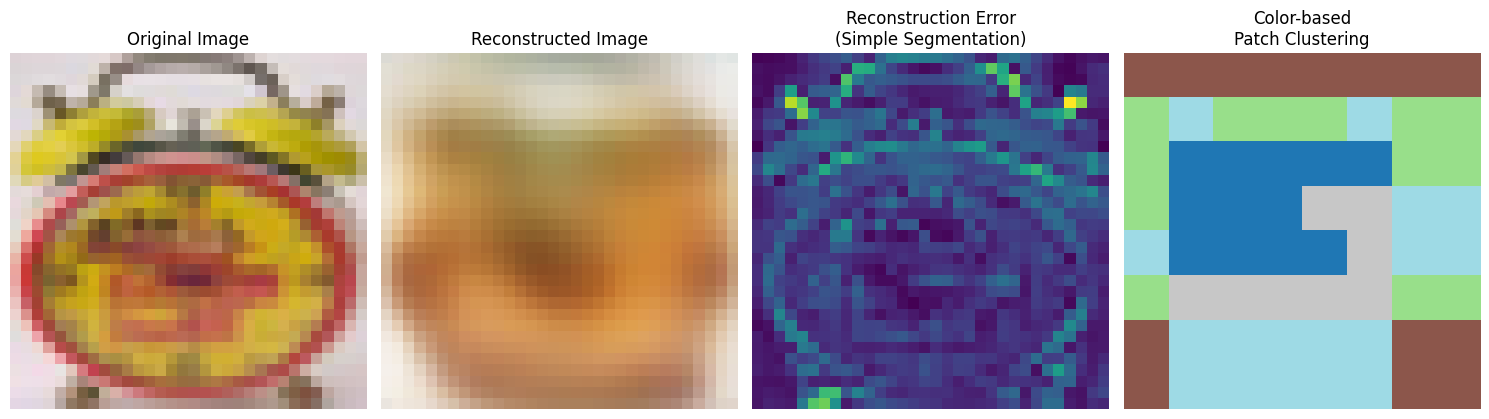

In [8]:

# --- Demonstration of pixel-wise segmentation approach ---
print("\n--- Demonstrating pixel-wise segmentation using the trained autoencoder ---")

# Select a test image to segment
test_idx = np.random.randint(0, len(x_test))
image = x_test[test_idx]
print(f"Selected image class: {cifar100_fine_labels[y_test[test_idx][0]]}")

# Approach 1: Use the autoencoder reconstruction as a simple form of segmentation
reconstructed = autoencoder.predict(np.expand_dims(image, axis=0))[0]
segmentation_mask = np.mean(np.abs(image - reconstructed), axis=-1)
segmentation_mask = (segmentation_mask - np.min(segmentation_mask)) / (np.max(segmentation_mask) - np.min(segmentation_mask))

# Approach 2: Extract patches and cluster their features
def extract_features_from_patches(image, patch_size=8, stride=4):
    h, w, c = image.shape
    patches = []
    positions = []
    
    for i in range(0, h-patch_size+1, stride):
        for j in range(0, w-patch_size+1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    
    patches = np.array(patches)
    return patches, positions

# Extract patches and positions
patches, positions = extract_features_from_patches(image)
print(f"Extracted {len(patches)} patches with shape {patches.shape}")

# Use color and texture features instead of encoder
patch_features = []
for patch in patches:
    # Create color features - mean and standard deviation of each channel
    r_mean = np.mean(patch[:,:,0])
    g_mean = np.mean(patch[:,:,1])
    b_mean = np.mean(patch[:,:,2])
    r_std = np.std(patch[:,:,0])
    g_std = np.std(patch[:,:,1])
    b_std = np.std(patch[:,:,2])
    # Simple texture feature - overall standard deviation
    texture = np.std(patch)
    # Combine features
    features = [r_mean, g_mean, b_mean, r_std, g_std, b_std, texture]
    patch_features.append(features)

patch_features = np.array(patch_features)
print(f"Generated feature array with shape {patch_features.shape}")

# Cluster the patch features
patch_clusters = KMeans(n_clusters=5, random_state=42, n_init=10).fit_predict(patch_features)

# Create a segmentation map from patch clusters
seg_map = np.zeros((32, 32))
for (i, j), cluster in zip(positions, patch_clusters):
    seg_map[i:i+8, j:j+8] = cluster

# Visualize the results
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(142)
plt.imshow(reconstructed)
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(143)
plt.imshow(segmentation_mask, cmap='viridis')
plt.title('Reconstruction Error\n(Simple Segmentation)')
plt.axis('off')

plt.subplot(144)
plt.imshow(seg_map, cmap='tab20')
plt.title('Color-based\nPatch Clustering')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Experiment with a more advanced segmentation approach

# Function to apply the autoencoder to segment parts of a larger image
def segment_real_image(image_path, encoder_model, patch_size=32):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Cannot load image: {image_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    
    # Extract patches and their positions
    patches = []
    positions = []
    for y in range(0, h-patch_size+1, patch_size//2):  # 50% overlap
        for x in range(0, w-patch_size+1, patch_size//2):
            patch = img[y:y+patch_size, x:x+patch_size]
            # Resize if needed to match autoencoder input
            patch = cv2.resize(patch, (32, 32))
            patches.append(patch / 255.0)  # Normalize
            positions.append((y, x))
    
    patches = np.array(patches)
    print(f"Extracted {len(patches)} patches.")
    
    # Get features for each patch
    features = encoder_model.predict(patches)
    
    # Cluster the features
    n_segments = 10  # Number of segments to create
    clusters = KMeans(n_clusters=n_segments, random_state=42, n_init=10).fit_predict(features)
    
    # Create segmentation map
    seg_map = np.zeros((h, w))
    for (y, x), cluster_id in zip(positions, clusters):
        seg_map[y:y+patch_size, x:x+patch_size] = cluster_id + 1  # +1 to avoid 0 values
    
    # Normalize segmentation map
    seg_map = seg_map / np.max(seg_map)
    
    # Visualize
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(seg_map, cmap='nipy_spectral')
    plt.title("Autoencoder-based Segmentation")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()



Extracted 1150 patches.
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


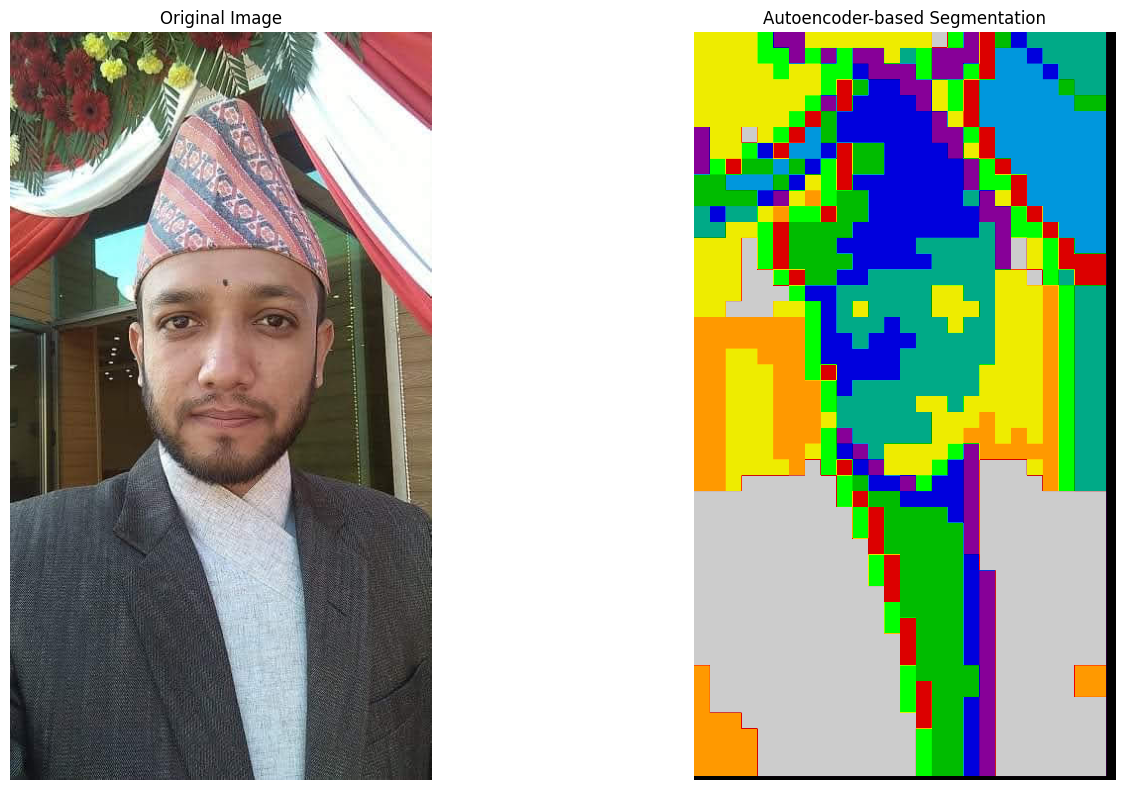

In [10]:
segment_real_image("data/saugat.jpeg", encoder)  # Example image path, replace with your own

# Understanding the Role of Clustering in Image Segmentation

The clustering step (using K-means) is a critical part of our unsupervised image segmentation approach. Here's why we're using clustering:

## 1. Dimensionality Reduction and Feature Extraction
- The autoencoder first compresses the images into a lower-dimensional representation (latent space)
- This latent space captures the most important features of the images in a compact form
- Each image is now represented by a vector of length `latent_dim` (128) instead of raw pixel values

## 2. Unsupervised Grouping
- Clustering allows us to group similar images together without requiring labels
- Images that have similar features in the latent space will be grouped into the same cluster
- This creates a "natural" organization of the image data based on visual similarity

## 3. Segmentation Approach
- For whole-image classification, clustering helps us discover natural categories in the data
- For within-image segmentation (as shown in cell 7), we apply the same principle but at the patch level:
  - Extract patches from an image
  - Encode each patch to get its latent representation
  - Cluster these representations to group similar regions
  - Map the cluster labels back to the original image space to create a segmentation map

This is a form of unsupervised segmentation because we don't need labeled training data to identify different regions within an image - the model learns to distinguish regions based on visual feature similarity.